In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [5]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip

--2020-12-22 08:48:25--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  32.5MB/s    in 2.3s    

2020-12-22 08:48:27 (32.5 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]



In [6]:
!unzip apple2orange.zip

Archive:  apple2orange.zip
   creating: apple2orange/
   creating: apple2orange/trainA/
  inflating: apple2orange/trainA/n07740461_6908.jpg  
  inflating: apple2orange/trainA/n07740461_7635.jpg  
  inflating: apple2orange/trainA/n07740461_586.jpg  
  inflating: apple2orange/trainA/n07740461_9813.jpg  
  inflating: apple2orange/trainA/n07740461_6835.jpg  
  inflating: apple2orange/trainA/n07740461_2818.jpg  
  inflating: apple2orange/trainA/n07740461_2918.jpg  
  inflating: apple2orange/trainA/n07740461_1213.jpg  
  inflating: apple2orange/trainA/n07740461_2476.jpg  
  inflating: apple2orange/trainA/n07740461_13596.jpg  
  inflating: apple2orange/trainA/n07740461_4093.jpg  
  inflating: apple2orange/trainA/n07740461_14738.jpg  
  inflating: apple2orange/trainA/n07740461_6477.jpg  
  inflating: apple2orange/trainA/n07740461_11356.jpg  
  inflating: apple2orange/trainA/n07740461_7594.jpg  
  inflating: apple2orange/trainA/n07740461_5119.jpg  
  inflating: apple2orange/trainA/n07740461_104

In [7]:
!ls apple2orange

testA  testB  trainA  trainB


In [8]:
import glob
apples_train = glob.glob('apple2orange/trainA/*.jpg')
oranges_train = glob.glob('apple2orange/trainB/*.jpg')
apples_test = glob.glob('apple2orange/testA/*.jpg')
oranges_test = glob.glob('apple2orange/testB/*.jpg')

In [9]:
len(apples_train), len(oranges_train), len(apples_test), len(oranges_test)

(995, 1019, 266, 248)

In [10]:
import cv2
for file in apples_train[:10]:
    img = cv2.imread(file)
    print (img.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Apples


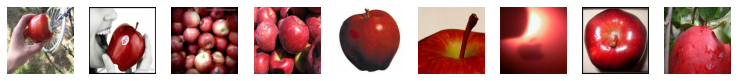

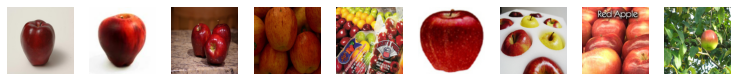

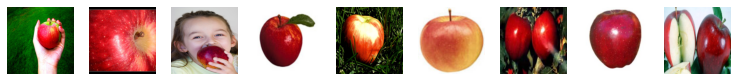

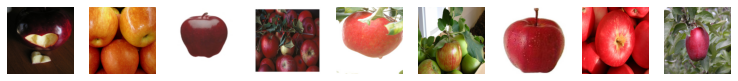

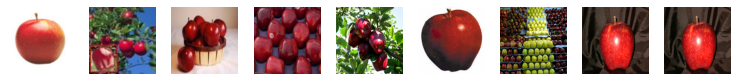

--------------------------------------------------------------------------------
Oranges


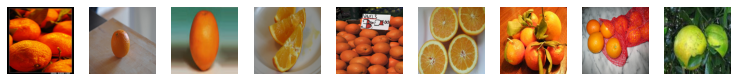

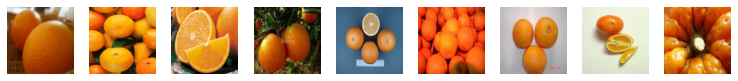

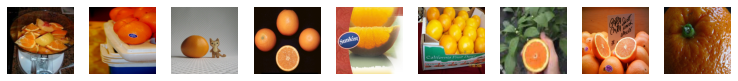

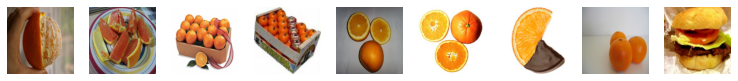

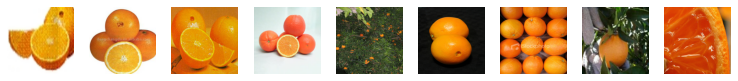

In [11]:
print ("Apples")
for k in range(5):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(apples_train)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Oranges")
for k in range(5):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(oranges_train)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (U-Net Like)

In [12]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [13]:
source_image_A = tensorflow.keras.layers.Input(shape=(256, 256, 3))
source_image_B = tensorflow.keras.layers.Input(shape=(256, 256, 3))
source_image = tensorflow.keras.layers.Input(shape=(256, 256, 3))

e1 = encoder_layer(source_image, 32, bn=False)
e2 = encoder_layer(e1, 64)
e3 = encoder_layer(e2, 128)
e4 = encoder_layer(e3, 256)
e5 = encoder_layer(e4, 256)
e6 = encoder_layer(e5, 256)
e7 = encoder_layer(e6, 256)

bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

d1 = decoder_layer(b, e7, 256)
d2 = decoder_layer(d1, e6, 256)
d3 = decoder_layer(d2, e5, 256)
d4 = decoder_layer(d3, e4, 256)
d5 = decoder_layer(d4, e3, 256)
d6 = decoder_layer(d5, e2, 64)
d7 = decoder_layer(d6, e1, 32)

decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)

generator_network_AB = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)
generator_network_BA = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

print (generator_network_AB.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1568        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   32832       leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Discriminator Network

In [14]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [15]:
target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

x = my_conv_layer(target_image_input, 64, bn=False)
x = my_conv_layer(x, 128)
x = my_conv_layer(x, 256)
x = my_conv_layer(x, 512)

patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)

discriminator_network_A = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)
discriminator_network_B = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network_A.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 256)       5245

In [16]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network_A.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])
discriminator_network_B.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Cycle-GAN

In [17]:
# Domain Transfer
fake_B = generator_network_AB(source_image_A)
fake_A = generator_network_BA(source_image_B)

# Restoring original Domain
get_back_A = generator_network_BA(fake_B)
get_back_B = generator_network_AB(fake_A)

# Get back Identical/Same Image
get_same_A = generator_network_BA(source_image_A)
get_same_B = generator_network_AB(source_image_B)
  
discriminator_network_A.trainable=False
discriminator_network_B.trainable=False

# Tell Real vs Fake, for a given domain
verify_A = discriminator_network_A(fake_A)
verify_B = discriminator_network_B(fake_B)

cycle_gan = tensorflow.keras.models.Model(inputs = [source_image_A, source_image_B], \
                              outputs = [verify_A, verify_B, get_back_A, get_back_B, get_same_A, get_same_B])
cycle_gan.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  16893635    input_2[0][0]                    
                                                                 model[0][0]                      
                                                                 input_1[0][0]                    
____________________________________________________________________________________________

# Compiling Models

In [18]:
cycle_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], loss_weights=[1, 1, 10, 10, 1, 1],\
                                          optimizer=adam_optimizer)

# Define Data Generators

In [20]:
def apples_to_oranges(apples, generator_network):
    generated_samples = generator_network.predict_on_batch(apples)
    return generated_samples

def oranges_to_apples(oranges, generator_network):
    generated_samples = generator_network.predict_on_batch(oranges)
    return generated_samples

def get_apple_samples(batch_size):
    random_files = np.random.choice(apples_train, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img-127.5)/127.5)
    apple_images = np.array(images)
    return apple_images

def get_orange_samples(batch_size):
    random_files = np.random.choice(oranges_train, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img-127.5)/127.5)
    orange_images = np.array(images)
    return orange_images

def show_generator_results_apples_to_oranges(generator_network_AB, generator_network_BA):
    images = []
    for j in range(5):
        file = np.random.choice(apples_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Apple Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(550 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated Orange Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = apples_to_oranges(np.array([img]), generator_network_AB)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(550 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated back to Apples')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = oranges_to_apples(np.array([img]), generator_network_BA)[0]
        output = (output+1.0)/2.0
        plt.subplot(550 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

def show_generator_results_oranges_to_apples(generator_network_AB, generator_network_BA):
    images = []
    for j in range(5):
        file = np.random.choice(oranges_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Orange Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(550 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated Apple Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = oranges_to_apples(np.array([img]), generator_network_BA)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(550 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated back to Oranges')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = apples_to_oranges(np.array([img]), generator_network_AB)[0]
        output = (output+1.0)/2.0
        plt.subplot(550 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [21]:
len(apples_train), len(oranges_train)

(995, 1019)

Input Apple Images


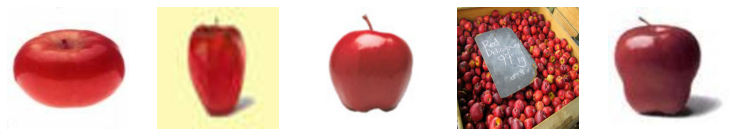

Translated Orange Images


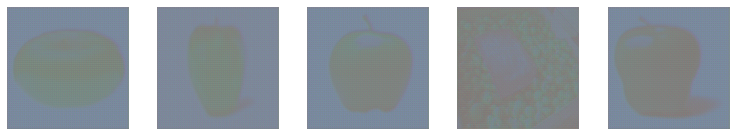

Translated back to Apples


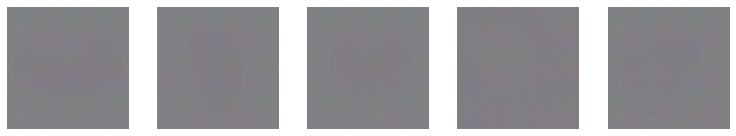

Epoch:0, Step:0, DA-Loss:18.235, DA-Acc:45.898, DB-Loss:7.339, DB-Acc:52.336, G-Loss:16.766
Epoch:0, Step:5, DA-Loss:1.718, DA-Acc:47.695, DB-Loss:1.343, DB-Acc:48.043, G-Loss:10.340
Epoch:0, Step:10, DA-Loss:0.670, DA-Acc:53.074, DB-Loss:0.513, DB-Acc:51.770, G-Loss:7.568
Epoch:0, Step:15, DA-Loss:0.380, DA-Acc:58.758, DB-Loss:0.381, DB-Acc:57.469, G-Loss:6.223
Epoch:1, Step:0, DA-Loss:0.313, DA-Acc:61.379, DB-Loss:0.308, DB-Acc:59.652, G-Loss:4.911
Epoch:1, Step:5, DA-Loss:0.284, DA-Acc:64.676, DB-Loss:0.298, DB-Acc:63.391, G-Loss:4.896
Epoch:1, Step:10, DA-Loss:0.659, DA-Acc:62.879, DB-Loss:0.511, DB-Acc:56.703, G-Loss:5.466


In [ ]:
epochs = 500
batch_size = 50
steps = 20

for i in range(0, epochs):
    if (i%5 == 0):
        show_generator_results_apples_to_oranges(generator_network_AB, generator_network_BA)
    for j in range(steps):  
        # A == Apples
        # B == Oranges
        domain_A_images = get_apple_samples(batch_size)
        domain_B_images = get_orange_samples(batch_size)

        fake_patch = np.zeros((batch_size, 16, 16, 1))
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        fake_B_images = generator_network_AB(domain_A_images)
        fake_A_images = generator_network_BA(domain_B_images)
        
        # Updating Discriminator A weights
        discriminator_network_A.trainable=True
        discriminator_network_B.trainable=False
        loss_d_real_A = discriminator_network_A.train_on_batch(domain_A_images, real_patch)
        loss_d_fake_A = discriminator_network_A.train_on_batch(fake_A_images, fake_patch)
        
        loss_d_A = np.add(loss_d_real_A, loss_d_fake_A)/2.0
        
        # Updating Discriminator B weights
        discriminator_network_B.trainable=True
        discriminator_network_A.trainable=False
        loss_d_real_B = discriminator_network_B.train_on_batch(domain_B_images, real_patch)
        loss_d_fake_B = discriminator_network_B.train_on_batch(fake_B_images, fake_patch)
        
        loss_d_B = np.add(loss_d_real_B, loss_d_fake_B)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network_A.trainable=False
        discriminator_network_B.trainable=False
        
        # Updating Generator weights
        loss_g = cycle_gan.train_on_batch([domain_A_images, domain_B_images],\
                    [real_patch, real_patch, domain_A_images, domain_B_images, domain_A_images, domain_B_images])
        
        if j%5 == 0:
            print ("Epoch:%.0f, Step:%.0f, DA-Loss:%.3f, DA-Acc:%.3f, DB-Loss:%.3f, DB-Acc:%.3f, G-Loss:%.3f"\
                   %(i,j,loss_d_A[0],loss_d_A[1]*100,loss_d_B[0],loss_d_B[1]*100,loss_g[0]))
            

In [ ]:
generator_network_AB.save("/content/gdrive/MyDrive/GAN_datasets/A2O_model")
generator_network_BA.save("/content/gdrive/MyDrive/GAN_datasets/O2A_model")